# 1. Set up environment

## 1.1 Install a Virtual env with all dependencies

### 1.1.1 UV Based Environment Creation
- Running below cell  requires [uv](https://docs.astral.sh/uv/) to be installed on your machine. 
- You can install from https://docs.astral.sh/uv/pip/environments/
- If you dont want UV please use pip based install

In [ ]:
%%bash
uv venv guarded_llm_env
source guarded_llm_env/bin/activate

uv pip install ipykernel nbconvert
uv pip install guardrails-ai --prerelease allow
python -m ipykernel install --user --name=guarded_llm_env


### 1.1.2 PIP Based Environment Creation
 - Uncomment below and run if you do want to not use above uv based install

In [ ]:
%%bash
python -m pip install --user virtualenv
python -m virtualenv guarded_llm_env
source guarded_llm_env/bin/activate
python -m pip install ipykernel nbconvert
python -m pip install guardrails-ai==0.6.6 
python -m pip install fastapi uvicorn nest-asyncio
python -m ipykernel install --user --name=guarded_llm_env

## 1.2 Activate the Kernel
- refresh the browser
- activate the _guarded_llm_env_ kernel


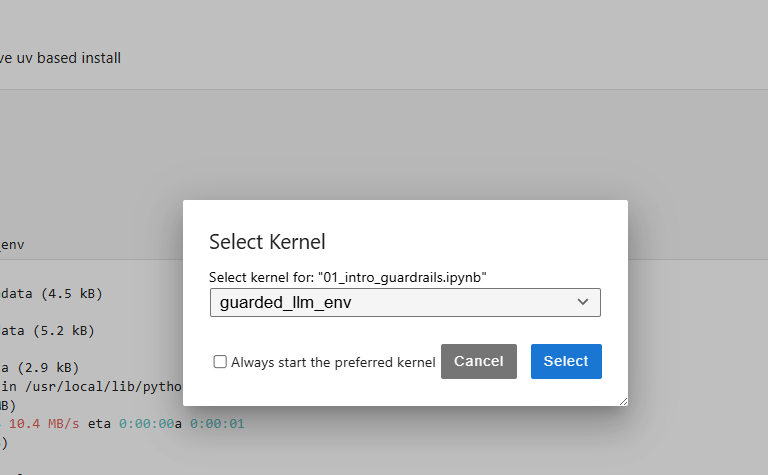

# 2. Normal (Unguarded) LLM Calls

## 2.1 Set up your LLM Provider and Authentication token


In [ ]:
#SET YOUR LLM PROVIDER KEY 
#https://platform.openai.com/settings/organization/api-keys
import os
os.environ["LLM_API_TOKEN"] = "sk-123" #ADD YOUR KEY HERE


In [ ]:
#INITIATE VARIABLES WITH YOUR LLM BASE AND TOKEN
LLM_PROVIDER_BASE="https://api.openai.com/v1"
LLM_API_TOKEN=os.environ["LLM_API_TOKEN"] 

In [ ]:
user_chat_request = {
     "messages":[
         {"role": "user", 
          "content": "You idiot, Generate fictional name and address of the Bank Customer with  .md list based formatting"}
     ],
    "stream":True,
    "max_tokens":150,
    "model": "gpt-3.5-turbo"
}

## 2.2 Make an normal LLM Call
- I am using litellm completion method here
- Reference : https://docs.litellm.ai/docs/completion/input

In [ ]:
import litellm
from typing import Dict, Any

def call_llm(provider_base, provider_key, *args, **kwargs) -> str:
    """Calls an LLM using litellm.completion."""

    #some bug in litellm version
    if "msg_history" in kwargs:
        kwargs.pop("msg_history")
        
    response = litellm.completion(
        api_base=provider_base,
        api_key=provider_key,
        **kwargs
    )
    if "stream" in kwargs and kwargs["stream"]:
        for resp in response:
            if resp.choices[0].delta.content:  # Some responses may not have content
                chunk = resp.choices[0].delta.content
                #print(chunk, end="", flush=True)  # Print in real-time
                yield chunk
    else:
         yield response['choices'][0]['message']['content']

In [ ]:
for chunk_resp in call_llm(provider_base=LLM_PROVIDER_BASE,
                            provider_key=LLM_API_TOKEN, 
                            **user_chat_request):
    print(chunk_resp, end="", flush=True)

# 3. Guarded LLM Calls

## 3.1 Install Guard from Guardrails HUB
 - Go to https://hub.guardrailsai.com/
 - Get Your token and configure it locally
 - Install your required guard

### 3.1.1 Configure Hub Token

In [ ]:
#get the token from https://hub.guardrailsai.com/keys and configure below
import os
os.environ["GR_TOKEN"]="GRTOKENHERE"


In [ ]:
%%bash
source guarded_llm_env/bin/activate
guardrails configure --disable-remote-inferencing --disable-metrics --token $GR_TOKEN

### 3.1.2 Install Guardrail From Hub
Below 2 validators are installed for thie demo 
- https://hub.guardrailsai.com/validator/guardrails/profanity_free
- https://hub.guardrailsai.com/validator/guardrails/guardrails_pii


In [ ]:
%%bash
source guarded_llm_env/bin/activate && guardrails hub install hub://guardrails/profanity_free



In [ ]:
%%bash
source guarded_llm_env/bin/activate && guardrails hub install hub://guardrails/guardrails_pii

## 3.2 Call LLM with Guardrails

### 3.2.1 Initialize Guardrail Objects

In [ ]:
import guardrails as gd
from guardrails import OnFailAction

#### 3.2.1.1 Profanity Guardrail Will be used to check for inputs

In [ ]:
from guardrails.hub import ProfanityFree
profanity_guard =  gd.Guard(name="Profanity").use(ProfanityFree, 
                                                  on_fail=OnFailAction.EXCEPTION)


#### 3.2.1.2 PII Guardrail Will be used to check for PII In LLM Response and FIX (MASK) it

In [ ]:
from guardrails.hub import GuardrailsPII
pii_guard =  gd.Guard(name="PII").use(GuardrailsPII, 
                                      entities=[ 'PERSON','LOCATION'], 
                                      on_fail=OnFailAction.FIX)


### 3.2.2 Apply GuardRails on Inputs

In [ ]:
def call_llm_guard_input(provider_base, provider_key, chat_request: Dict[str, Any], guard_to_apply=None) -> str:
    """Validates LLM Input with  Guard"""
    if guard_to_apply:
        #Validate Input Only
        try:
            for msg in chat_request["messages"]:
                guard_to_apply.validate(msg["content"])
        except Exception as e:
            error_str = "INPUT_GUARD_FAILED::" + str(e)
            yield error_str

            
    else:
        for chunk_resp in call_llm(provider_base=LLM_PROVIDER_BASE,
                                   provider_key=LLM_API_TOKEN,
                                   **user_chat_request):
            yield chunk_resp

In [ ]:
#Call with Input Guards
for chunk_resp in call_llm_guard_input(provider_base=LLM_PROVIDER_BASE, 
                                       provider_key=LLM_API_TOKEN, 
                                       chat_request=user_chat_request, 
                                       guard_to_apply=profanity_guard):
    print(chunk_resp, end="", flush=True)

### 3.2.3 Apply GuardRails on Inputs plus Outputs

In [ ]:
def call_llm_guard_output(provider_base, provider_key, chat_request: Dict[str, Any], guard_to_apply=None) -> str:
    """Validates Output Generated by an Input"""
    if guard_to_apply:
        
        try:
            llm_output_gen =guard_to_apply(call_llm,provider_base=LLM_PROVIDER_BASE, provider_key=LLM_API_TOKEN, **chat_request)
            for validation_outcome in llm_output_gen:
                if validation_outcome.validation_passed==True or guard_to_apply.validators[0].on_fail=="fix":
                    yield validation_outcome.validated_output
        except Exception as e:
            error_str = "OUTPUT_GUARD_FAILED::" + str(e)
            yield error_str        
            
    else:
        for chunk_resp in call_llm(provider_base=LLM_PROVIDER_BASE,
                                   provider_key=LLM_API_TOKEN, 
                                   **user_chat_request):
            yield chunk_resp


In [ ]:
#Call LLM with OUTPUT  Guards
for chunk_resp in call_llm_guard_output(provider_base=LLM_PROVIDER_BASE,
                                        provider_key=LLM_API_TOKEN,
                                        chat_request=user_chat_request,
                                        guard_to_apply=pii_guard):
    print(chunk_resp, end="", flush=True)

In [ ]:
def call_llm_guarded(provider_base, provider_key, chat_request: Dict[str, Any], input_guard_to_apply=None, output_guard_to_apply=None) -> str:
    """Calls an LLM with Guard"""
    if input_guard_to_apply:

        #Validate Input Only
        try:
            for msg in chat_request["messages"]:
                input_guard_to_apply.validate(msg["content"])
            if output_guard_to_apply:
                    try:
                        llm_output_gen = output_guard_to_apply(call_llm,
                                                        provider_base=LLM_PROVIDER_BASE, 
                                                        provider_key=LLM_API_TOKEN, 
                                                        **chat_request)
                        for validation_outcome in llm_output_gen:
                            if validation_outcome.validation_passed==True or output_guard_to_apply.validators[0].on_fail=="fix":
                                yield validation_outcome.validated_output
                    except Exception as e:
                        error_str = "OUTPUT_GUARD_FAILED::" + str(e)
                        yield error_str   
        except Exception as e:
            error_str = "INPUT_GUARD_FAILED::" + str(e)
            yield error_str
            
     
            
            
    else:
        for chunk_resp in call_llm(provider_base=LLM_PROVIDER_BASE,
                                   provider_key=LLM_API_TOKEN,
                                   **user_chat_request):
            yield chunk_resp


In [ ]:
#Call LLM with INOUT + OUTPUT  Guards
for chunk_resp in call_llm_guarded(provider_base=LLM_PROVIDER_BASE, 
                                        provider_key=LLM_API_TOKEN, 
                                        chat_request=user_chat_request,
                                        input_guard_to_apply=profanity_guard,
                                        output_guard_to_apply=pii_guard):
    print(chunk_resp, end="", flush=True)

#above would still fail input profanity validator check

In [ ]:
#below will not face input validation and for output streaming the validation failures are fixed
user_chat_request_new = {
     "messages":[
         {"role": "user", 
          "content": "Get me the fictional name and address of the person with no formatting"}
     ],
    "stream":True,
    "max_tokens":150,
    "model": "gpt-3.5-turbo"
}

In [ ]:
#Call LLM with INOUT + OUTPUT  Guards
for chunk_resp in call_llm_guarded(provider_base=LLM_PROVIDER_BASE, 
                                        provider_key=LLM_API_TOKEN, 
                                        chat_request=user_chat_request_new,
                                        input_guard_to_apply=profanity_guard,
                                        output_guard_to_apply=pii_guard):
    print(chunk_resp, end="", flush=True)